In [1]:
#Loading Libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 

Dự án được chia thành bốn phần

**Phần một: Mô hình phân loại chữ số**

Xây dựng và đào tạo mạng nơ-ron trên tập dữ liệu hình ảnh Chars74K cho các chữ số. Điều này sẽ được sử dụng nhiều hơn trong việc phân loại các chữ số trong hình ảnh.

**Phần hai: Phát hiện và đọc Sudoku từ một hình ảnh**

Xác định câu đố sudoku trong một hình ảnh bằng cách sử dụng thư viện OpenCV.
Phân loại các chữ số trong câu đố sudoku được phát hiện bằng cách sử dụng mô hình được thực hiện trong phần một.
Nhận giá trị của các ô trong sudoku trong cho mảng.

**Phần ba: Mô hình giải câu đố sudoku**

**Phần ba: Giải câu đố**

Mảng được chuyển đổi thành ma trận.
Câu đố đã cho được giải bằng cách sử dụng đệ quy.

# Phần 1. Mô hình phân loại chữ số

# Phần 2
**Trong phần này:**

* Đọc một hình ảnh từ tập dữ liệu
* Xử lý hình ảnh

In [2]:
model = keras.models.load_model(r'D:/Nam4/ComputerVision/Project/Sudoku/classify.h5')

_83_3762379.jpeg


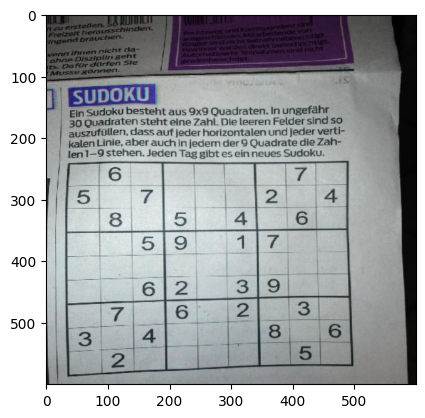

In [15]:
# Randomly select an image from the dataset 

folder=r"D:/Nam4/ComputerVision/Project/Sudoku/data"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show()

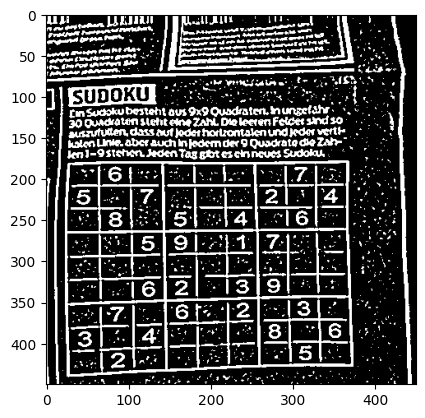

In [16]:
#Việc phát hiện đường viền có độ chính xác cao hơn khi sử dụng hình ảnh nhị phân
#Preprocessing image to be read
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) #làm mịn để giảm nhiễu
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2) #Lấy ngưỡng
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold, cmap='gray')
plt.show()

**DETECTING CONTOUR**

* Phát hiện đường viền lớn nhất của hình ảnh
* Định hình lại đường viền đẻ có được Sudoku đã được cắt xén và căn chỉnh tốt

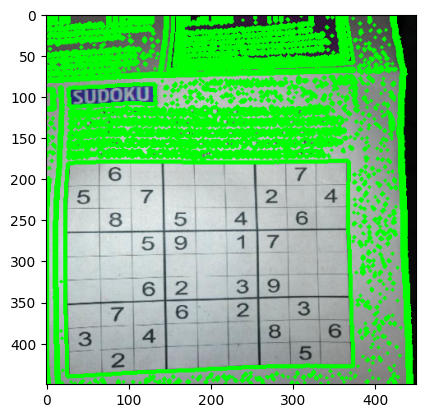

In [17]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
#Tìm đường viền
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

Tuy nhiên, một số hình ảnh không phù hợp để sử dụng trong mô hình này (một số hình ảnh bị mờ hoặc bị xén viền)

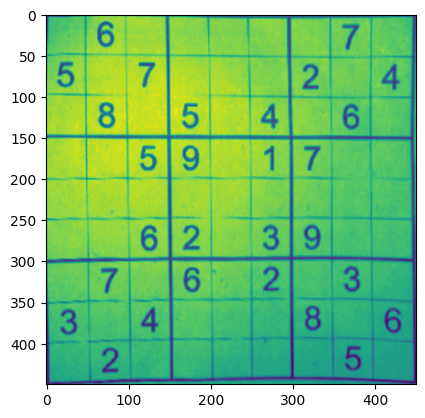

In [18]:
#Tìm đường viền chính và diện tích lớn nhất. Biggest có shape là (4, 1, 2) tương đương với 4 điếm tọa độ 4 góc
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9) #chia ma trận thành 9 mảng con theo hàng ngang
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9) #chia mảng thành 9 mảng con theo hàng cột
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450)) #Hàm căn chỉnh ảnh cho vuông góc
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

**Cắt dòng và phân loại số**

* Tách ô sudoku thành 81 ô với khoảng trống hoặc chữ số
* Cắt các ô để tránh phát hiện sai các đường ranh giới dưới dạng chữ số
* Sử dụng mô hình để phân loại các chữ số trong các ô sao cho các ô trống được phân loại là 0
* Nhận đầu ra được phát hiện dưới dạng một mảng gồm 81 chữ số

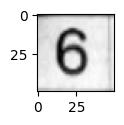

In [28]:
sudoku_cell = splitcells(imagewrap)
#Let's have alook at the last cell
plt.figure(figsize=(1, 1))
plt.imshow(sudoku_cell[1], cmap='gray')
plt.show()

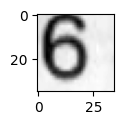

In [31]:
a = sudoku_cell[1][10:45, 10:45]
plt.figure(figsize=(1, 1))
plt.imshow(a, cmap='gray')
plt.show()

In [32]:
te = cv2.resize(a, (28, 28))
te = te/255
te = te.reshape(1, 28, 28, 1)
model.predict(te)

1/1 [==============================] - 0s 58ms/step


array([[6.2983311e-03, 8.0112204e-07, 2.3089615e-07, 2.3812510e-04,
        6.8353705e-09, 1.3430706e-03, 9.9193782e-01, 2.2620372e-06,
        1.7191267e-04, 7.3153556e-06]], dtype=float32)

In [22]:
te = cv2.resize(sudoku_cell[18], (28, 28))
te = te/255
te = te.reshape(1, 28, 28, 1)
model.predict(te)

1/1 [==============================] - 0s 37ms/step


array([[1.5352125e-02, 9.4750440e-01, 7.4788148e-04, 2.1553666e-03,
        9.5925119e-05, 7.1989382e-03, 7.2936738e-05, 4.4027023e-04,
        3.2995371e-03, 2.3132674e-02]], dtype=float32)

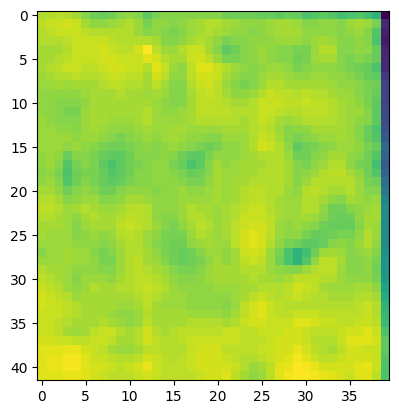

In [23]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[2])
plt.show()

In [24]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model 
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (28, 28))
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
        img = cv2.equalizeHist(img) #tăng độ tương phản
        img = img/255
        img = img.reshape(1, 28, 28, 1)
        # getting predictions and setting the values if probabilities are above 65% 
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions)
        # probabilityValue = np.amax(predictions)
        
        if classIndex > 0.5:
            result.append(classIndex)
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

1/1 [==============================] - 0s 2ms/step


**PART 3. XỬ LÝ SUDOKU**

* Định hình lại mảng thành ma trận 9 x 9 

* Giải ma trận bằng đệ quy

In [25]:
# Reshaping the grid to a 9x9 matrix

grid = np.reshape(grid,(9,9))
grid

array([[3, 3, 2, 6, 1, 1, 1, 1, 1],
       [5, 7, 6, 7, 4, 1, 7, 1, 9],
       [1, 6, 1, 5, 4, 4, 6, 3, 1],
       [1, 1, 5, 9, 1, 7, 7, 7, 1],
       [7, 6, 0, 6, 0, 5, 1, 6, 6],
       [4, 7, 6, 7, 4, 6, 9, 6, 6],
       [4, 7, 1, 6, 7, 7, 7, 6, 0],
       [3, 4, 4, 7, 1, 4, 6, 0, 0],
       [1, 7, 2, 1, 8, 0, 5, 9, 4]], dtype=int64)

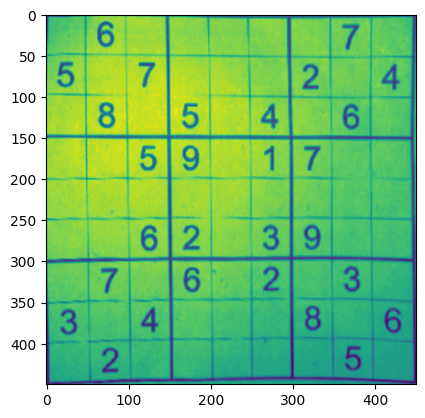

In [26]:
#For compairing 
plt.figure()
plt.imshow(imagewrap)
plt.show()